# Cosmology final project: bayesian inference

For this project, we will see how Bayesian Inference is used in cosmology and astrophysics. To do so, I will implement the Metropolis-Hasting algorithm to sample a Posterior and infer three parameters for a given model.

Let's start with the Metropolis-Hasting algorithm. The general equation of the Bayes theorem for parameter inference is:

$$P(\vec{\theta}|Data, Model) = \frac{\mathcal{L}(Data|\vec{\theta}, Model)Pr(\vec{\theta})}{E(Data, Model)} ⟹ p(w|x,t) = \frac{p(t|x,w)p(w)}{N}$$

Where:
* $P(\vec{\theta}|Data, Model)$ is the posterior
* $\mathcal{L}(Data|\vec{\theta}, Model)$ is the Likelihood
* $Pr(\vec{\theta})$ is the Prior
* $E(Data, Model)$ is the evidence

The E is usually a normalized constant that can be obtained from an integral with no-analytic solution. We will not select different models, so it is not important to compute it. Thus, we can write:

$$P(\vec{\theta}|Data, Model) \propto \mathcal{L}(Data|\vec{\theta}, Model)Pr(\vec{\theta})⟹ p(w|x,t) \propto p(t|x,w)p(w)$$

However, it's better to work with:

$$log(P) \propto log(\mathcal{L}) + log(Pr)$$

To prove whether the algorithm works or not, we will test it by fitting a straight line with a linear model.

The main process is as follows:
1. Select a $\vec{\theta}_{start} = \vec{\theta}_{i}$.
2. Proporse a $\vec{\theta}_{trial}$ from a normal distribution $\mathcal{N}(\vec{\theta}_i, \sigma)$, with $\sigma = Diag(\sigma_1, \sigma_2,..., \sigma_n)$.
3. Compute acceptance probability $p_{acc} = min(1, P(\vec{\theta}_{trial})/ P(\vec{\theta}_i))$.
4. If $p_{acc} > u \in U(0,1))$ (select a random number $u$ between 0 and 1), then we will accept the proposal value and $\vec{\theta}_{i+1} = \vec{\theta}_{trial}$. If not, $\vec{\theta}_{i+1} = \vec{\theta}_i$ (we won't move from the current proposed value).

We will repeat the previous four steps for n iterations until convergence (graphically, the points will be agglomerated in a particular region).

It is also necessary the value for the likelihood:

$$\mathcal{L} \propto \prod_i^n \frac{1}{2\pi\sigma_i^2} exp\left(-\frac{(x_i-\mu)^2}{2\sigma_i^2}\right) \Longrightarrow \mathcal{L} = -log(2\pi\sigma_i^2) - \frac{(x_i-\mu)^2}{2\sigma_i^2}$$

and the prior:

$$Pr = \frac{1}{\theta} \Longrightarrow log\left(\frac{1}{\theta}\right)$$

Also, since we are using logarithms for the likelihood (it is better to work with logarithms instead of probabilities), we will use a logarithm for the priors, and then an exponential in the posterior.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## MH algorithm for a straight line

In [ ]:
# Parameters #
m, b = 2, 4                   # gradient (slide) and intercept on the y-axix
std = 0.4                     # standar deviation of the data (proposed)

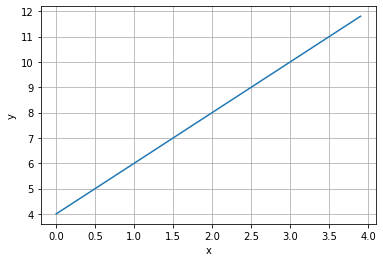

(None, None)

In [ ]:
# Our distribution will be a straight line

# This function will receive the proposed values from the method to compare them
# with the likelihood:
def function(x,valores=[m,b]):
  m=valores[0]
  b=valores[1]
  f = m*x + b
  return f
# We should expect an approximation of the following plot
x = np.arange(0, 4, 0.1)
y = function(x)
plt.plot(x, y)
plt.xlabel("x"), plt.ylabel("y")
plt.grid(), plt.show()

In [ ]:
# Prior
# First prior: the proposed values are compared with the limits (given by the users), 
# if they go beyond these, a value is taken that when passing through the logarithm 
# returns a negative, this will decrease its probability of being accepted.
"""
def prior(prop, lim_b, lim_m):
  if prop[1] > lim_m[0] and prop[1] < lim_m[1]:
    mPrior = stats.norm(0.4, 0.4).pdf(m) # sd is proposed 

  else:
    mPrior= 0.1

  if prop[0] > lim_b[0] and prop[0] < lim_b[1]:
    bPrior = stats.norm(0.4, 0.4).pdf(b)

  else:
    bPrior= 0.1

  return np.log(mPrior) + np.log(bPrior) 
"""
# Second prior: this could generate issues with the log, but you can run the code again to avoid it
def prior(prop, lim_b, lim_m): # Using Jeffrey's prior
  mPrior = 1/prop[0]                        
  bPrior = 1/prop[1]
  return np.log(mPrior) + np.log(bPrior)

# Likelihood
def likelihood(x, datos, desv, prop): # Likelihood receives the values of x and y generated in the linear function above to compare it in our model
  #likeli = np.log(1/(2*np.pi*desv**2))-(((datos-function(x, prop))/desv)**2)/2      # Function for straight line
  likeli = - np.log(2*np.pi*desv**2) - (((datos-function(x, prop))/desv)**2)/2      # Function for straight line
  return sum(likeli)

# Generation of theta_trial (proposed new parameter)
# Theta_trial receives the previous value of m and b, and generates new ones in the neighborhoods
def theta_trial(lm, lb, std):
  thetaTrial1 = np.random.normal(loc = lm, scale = std/10) # proposed value for slope with normal distribution
  thetaTrial2 = np.random.normal(loc = lb, scale = std/10) # proposed value for the intercept with normal distribution
  return thetaTrial1, thetaTrial2

In [ ]:
# MH algorithm
def MHalg(IMax, lim_b, lim_m, ni, std):
  global storage2
  storage2 = []
  storage=[]
  
  i = 0           # This will prevent a infinite loop later on

  # Here we create our theta_trial (initial free parameters: m and b) from a normal distribution
  mi, bi= theta_trial(np.random.uniform(lim_b[0], lim_b[1]), np.random.uniform(lim_m[0], lim_m[1]), std) #, theta_trial(lim_m, (std, std))
  storage.append((mi, bi))
  #print("Initial parameters (m,b):", storage)

  lik = likelihood(x, y, std, storage[-1])              # Likelihood
  post_i = lik-prior(storage[-1], lim_b, lim_m)         # Posterior

  while i < IMax and len(storage) < ni:

    t_trial = theta_trial(storage[-1][0], storage[-1][1], std)       # proposed theta (free parameters)
    lik = likelihood(x, y, std, t_trial)                             # proposed likelihood
    post = lik-prior(t_trial, lim_b, lim_m)                          # posterior

    # We need to use exponential, since we used logarithms for likelihood and prior
    p_acc = np.exp(post - post_i)                           # Compute the acceptance probability 
    u = np.random.uniform(0,1)                              # Choose a u between 0 and 1
    p_acc = min(1, p_acc)
    
    if p_acc > u:      # Accept proposal 
      post_i = post
      storage.append(t_trial)           # The accepted value is storaged

    i += 1

  acc=np.zeros((2, len(storage)))
  for i in range(len(storage)):         # arrays are created that will store the accepted values of m and b
    acc[0][i]=storage[i][0]
    acc[1][i]=storage[i][1]

  storage2.append(storage[-1])          # Storage the accepted values
  print(storage[-1])                    # Print last value accepted
  print(len(storage))                   # Iterations

  return acc

(1.9700151899179341, 4.053408489958607)
5592
(2.080876231055459, 3.7720585801551336)
5605
(2.0480784117480395, 3.8331459931466307)
5617
(1.9776570829529558, 3.9860354623825183)
5589
(1.9723266343197206, 3.966876351241001)
5569


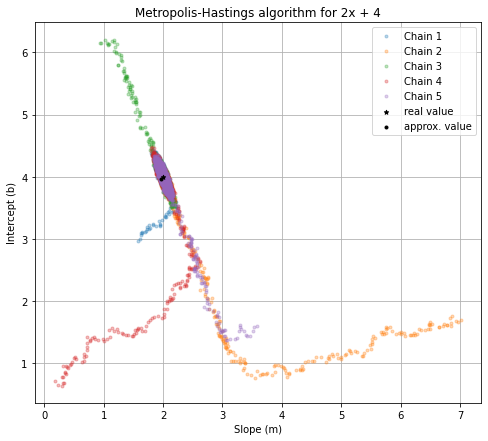

In [ ]:
i_max=10000         # Total of iterations
limb=[0,8]          # Search limits for b
limm=[0,8]          # Search limits for m
narr=9000          # iteration stop

fig, ax = plt.subplots(1, figsize=(8,7))

for i in range(5):
  lines=MHalg(i_max, limb, limm, narr, std)
  plt.plot(lines[:][0], lines[:][1], ".", alpha=0.3, label='Chain ' + str(i+1))

plt.scatter(m, b, color='k', marker = '*', s = 20,  alpha = 1, label='real value', zorder=3)
plt.scatter(storage2[-1][0], storage2[-1][1], color='k', marker = '.', label='approx. value', zorder=3)
plt.title('Metropolis-Hastings algorithm for ' + str(m) + 'x + ' + str(b))
plt.xlabel('Slope (m)')
plt.ylabel('Intercept (b)')
plt.legend()
plt.grid()
plt.savefig("MHalg.png")
plt.show()

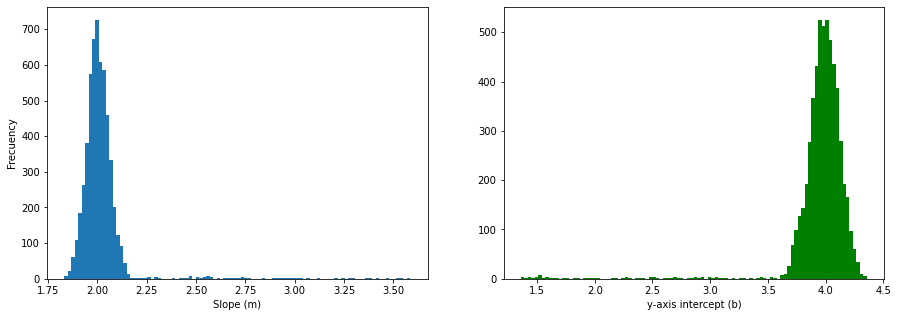

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
# Histograms from chain 5
ax[0].hist(lines[:][0], bins = 100)
ax[0].set_xlabel("Slope (m)")
ax[0].set_ylabel("Frecuency")
ax[1].hist(lines[:][1], bins = 100, color = 'g')
ax[1].set_xlabel("y-axis intercept (b)")
ax[1].figure.savefig('Hist_Line.png')
plt.show()

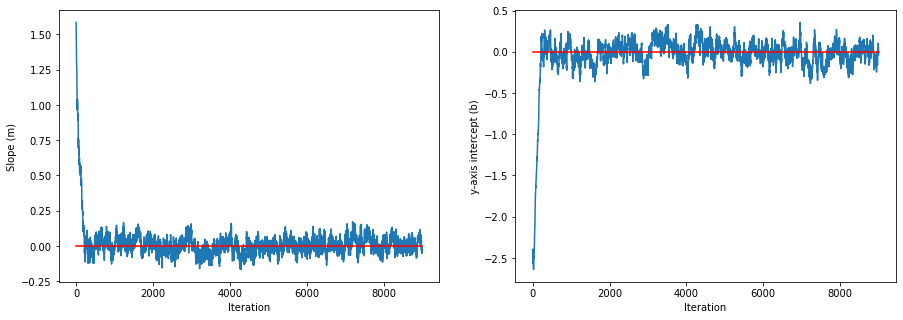

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
xp = np.linspace(0,9000, 2)
yp = np.zeros(2)
# Trace plot from chain 5
ax[0].plot(np.linspace(0,9000, len(lines[:][0])), lines[:][0]-m)
ax[0].plot(xp, yp, color='r')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Slope (m)")
ax[1].plot(np.linspace(0,9000, len(lines[:][1])), lines[:][1]-b)
ax[1].plot(xp, yp, color='r')
ax[1].set_ylabel("y-axis intercept (b)")
ax[1].set_xlabel("Iteration")
ax[1].figure.savefig('TracePlotLine.png')
plt.show()

## MH for supernova data
Now that we see that the method works correctly, we can proceed to use it in a cosmological application: supernova data fitting. For this section, we will use the cosmolopy library and the data from Kowalski et al. article, available in https://supernova.lbl.gov/Union/figures/SCPUnion_mu_vs_z.txt.

In [ ]:
from astropy.cosmology import FlatLambdaCDM
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install CosmoloPy #  Need to install for evaluating models with curvature
import cosmolopy.distance as cd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 11.4 MB/s 


In [ ]:
# Definition of parameters
H0 = 67.36
Om0 = 0.3153                    # Free parameter 1
Ob0 = 0.02237/(H0/100)**2       
OLambda = 0.6847                # Free parameter 2
Tcmb0 = 2.7255

cosmo = {'omega_M_0' : Om0, 'omega_lambda_0' : OLambda,'h' : H0/100}
cosmo = cd.set_omega_k_0(cosmo)
print(cosmo)
#param = [0.3111, 0.6889] # this will set the dependency of two parameters in mu (values from the Planck experiment, as in the project)
param = [Om0, OLambda]

{'omega_M_0': 0.3153, 'omega_lambda_0': 0.6847, 'h': 0.6736, 'omega_k_0': 0.0}


In [ ]:
# Supernovae data is imported
data=np.loadtxt("/content/drive/MyDrive/SCPUnion_mu_vs_z.txt",usecols=(1,2,3)).T

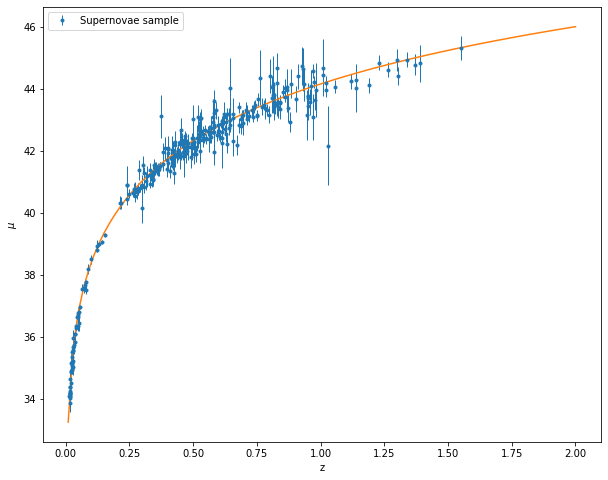

In [ ]:
# Fit is tested
z = np.linspace(0.01, 2, 100)
figure, axes = plt.subplots(1, figsize=(10,8))
plt.errorbar(data[0], data[1], yerr = data[2], fmt='.', elinewidth=1, label = 'Supernovae sample')
plt.plot(z, mu(z, param))
aco_z = mu(z, param)

plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend()
#plt.legend(loc = 'lower right')

In [ ]:
# Distance modulus
def mu(z, param):
  # We use the same parameters defined at the beginning to compute the luminosity distance
  cosmo = {'omega_M_0' : param[0], 'omega_lambda_0' : param[1],'h' : H0/100}
  cosmo = cd.set_omega_k_0(cosmo)
  return 5. * np.log10(cd.luminosity_distance(z, **cosmo)) + 25

#Find Best Fit 
def chi2(param):
  model = mu(data[0], param) 
  return  np.sum((data[1] - model)**2./data[2]**2) 

In [ ]:
# Prior
# First prior: the proposed values are compared with the limits (given by the users), 
# if they go beyond these, a value is taken that when passing through the logarithm 
# returns a negative, this will decrease its probability of being accepted.
"""
def prior(prop, lim_b, lim_m):
  if prop[1] > lim_m[0] and prop[1] < lim_m[1]:
    mPrior = stats.norm(0.4, 0.4).pdf(m) # sd is proposed 

  else:
    mPrior= 0.1

  if prop[0] > lim_b[0] and prop[0] < lim_b[1]:
    bPrior = stats.norm(0.4, 0.4).pdf(b)

  else:
    bPrior= 0.1

  return np.log(mPrior) + np.log(bPrior) 
"""
# Second prior: this could generate issues with the log, but you can run the code again to avoid it
def prior(prop, lim_b, lim_m): # Using Jeffrey's prior
  mPrior = 1/prop[0]                        
  bPrior = 1/prop[1]
  return np.log(mPrior) + np.log(bPrior)

# Likelihood
def likelihood(x, datos, desv, prop): # Likelihood receives the values of x and y generated in the linear function above to compare it in our model
  likeli = - np.log(2*np.pi*desv**2) - (((datos-mu(x, prop))/desv)**2)/2
  return sum(likeli)

# Generation of theta_trial (proposed new parameter)
# Theta_trial receives the previous value of m and b, and generates new ones in the neighborhoods
def theta_trial(lm, lb, std):
  thetaTrial1 = np.random.normal(loc = lm, scale = std/10) # proposed value for slope with normal distribution
  thetaTrial2 = np.random.normal(loc = lb, scale = std/10) # proposed value for the intercept with normal distribution
  return thetaTrial1, thetaTrial2

In [ ]:
# MH algorithm
def MHalg(IMax, lim_b, lim_m, ni, std):
  global storage3
  storage3 = []
  storage=[]
  
  i = 0           # This will prevent a infinite loop later on

  # Here we create our theta_trial (initial free parameters: m and b) from a normal distribution
  mi, bi= theta_trial(np.random.uniform(lim_b[0], lim_b[1]), np.random.uniform(lim_m[0], lim_m[1]), std) #, theta_trial(lim_m, (std, std))
  storage.append((mi, bi))
  #print("Initial parameters (m,b):", storage)

  lik = likelihood(z, aco_z, std, storage[-1])              # Likelihood
  post_i = lik-prior(storage[-1], lim_b, lim_m)                     # Posterior

  while i < IMax and len(storage) < ni:

    t_trial = theta_trial(storage[-1][0], storage[-1][1], std)       # proposed theta (free parameters)
    lik = likelihood(z, aco_z, std, t_trial)                             # proposed likelihood
    post = lik-prior(t_trial, lim_b, lim_m)                          # posterior

    # We need to use exponential, since we used logarithms for likelihood and prior
    p_acc = np.exp(post - post_i)                           # Compute the acceptance probability 
    u = np.random.uniform(0,1)                              # Choose a u between 0 and 1
    p_acc = min(1, p_acc)
    
    if p_acc > u:      # Accept proposal 
      post_i = post
      storage.append(t_trial)           # The accepted value is storaged

    i += 1

  acc=np.zeros((2, len(storage)))
  for i in range(len(storage)):         # arrays are created that will store the accepted values of m and b
    acc[0][i]=storage[i][0]
    acc[1][i]=storage[i][1]

  storage3.append(storage[-1])          # Storage the accepted values
  print(storage[-1])                    # Print last value accepted
  print(len(storage))                   # Iterations

  return acc

(0.3318272365322714, 0.6952070241051856)
6937
(0.3103454288476482, 0.6840159972946266)
7043
(0.2875585635322866, 0.6305007258052142)
7014
(0.30327990189067106, 0.6837240116112269)
6965
(0.2957486664704988, 0.6364919684781853)
6982


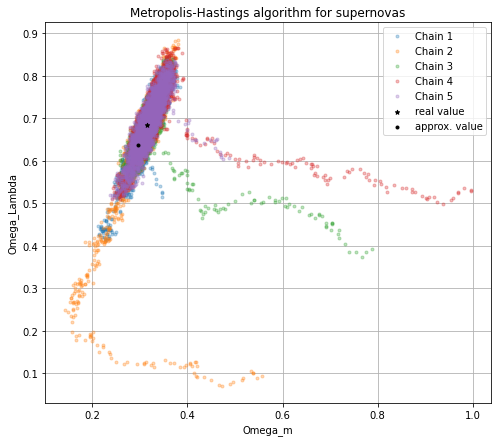

In [ ]:
i_max=10000         # Total of iterations
limb=[0,1]          # Search limits for b
limm=[0,1]          # Search limits for m
narr=9000          # iteration stop
std = 0.09

fig, ax = plt.subplots(1, figsize=(8,7))

for i in range(5):
  lines=MHalg(i_max, limb, limm, narr, std)
  plt.plot(lines[:][0], lines[:][1], ".", alpha=0.3, label='Chain ' + str(i+1))

plt.scatter(Om0, OLambda, color='k', marker = '*', s = 20,  alpha = 1, label='real value', zorder=3)
plt.scatter(storage3[-1][0], storage3[-1][1], color='k', marker = '.', label='approx. value', zorder=3)
plt.title('Metropolis-Hastings algorithm for supernovas')
plt.xlabel('Omega_m')
plt.ylabel('Omega_Lambda')
plt.legend()
plt.grid()
plt.savefig("MHalgNOVA.png")
plt.show()

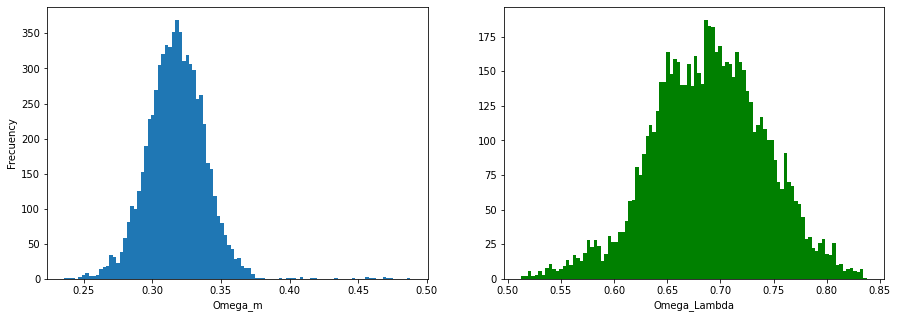

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
# Histograms from chain 5
ax[0].hist(lines[:][0], bins = 100)
ax[0].set_xlabel("Omega_m")
ax[0].set_ylabel("Frecuency")
ax[1].hist(lines[:][1], bins = 100, color = 'g')
ax[1].set_xlabel("Omega_Lambda")
ax[1].figure.savefig('Hist_LineNOVA.png')
plt.show()

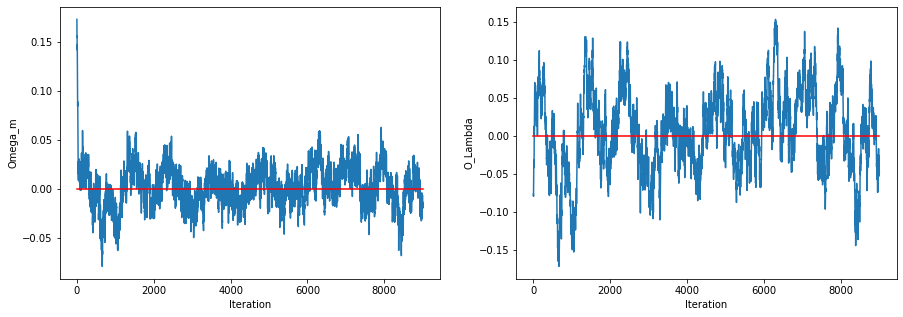

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
xp = np.linspace(0,9000, 2)
yp = np.zeros(2)
# Trace plot from chain 5
ax[0].plot(np.linspace(0,9000, len(lines[:][0])), lines[:][0]-Om0)
ax[0].plot(xp, yp, color='r')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Omega_m")
ax[1].plot(np.linspace(0,9000, len(lines[:][1])), lines[:][1]-OLambda)
ax[1].plot(xp, yp, color='r')
ax[1].set_ylabel("O_Lambda")
ax[1].set_xlabel("Iteration")
ax[1].figure.savefig('TracePlotLineNOVA.png')
plt.show()

### Comparison and real data

In [ ]:
# Chi squared minimization
res1 = minimize(chi2, param, method='L-BFGS-B', bounds=[(0,0.999), (0,0.999)]) # Here we set array pairs for each value in x0 = param
res1

      fun: 328.5157295101217
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.09494702e-05, -3.52429197e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 11
   status: 0
  success: True
        x: array([0.21341795, 0.36742039])

In [ ]:
param2 = [storage3[-1][0], storage3[-1][1]]

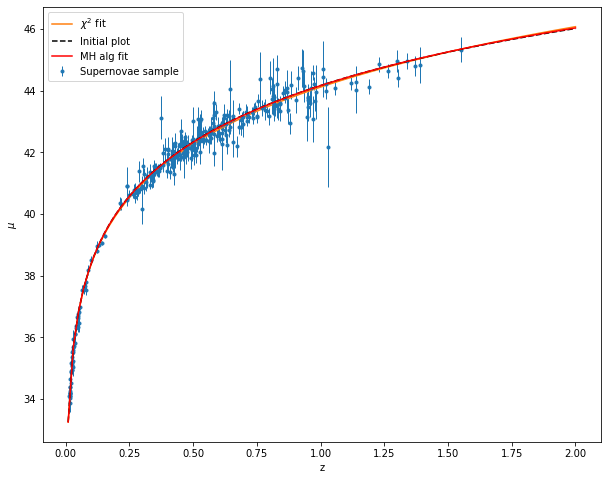

In [ ]:
# Fit is tested
z = np.linspace(0.01, 2, 100)
figure, axes = plt.subplots(1, figsize=(10,8))
plt.errorbar(data[0], data[1], yerr = data[2], fmt='.', elinewidth=1, label = 'Supernovae sample')
plt.plot(z, mu(z, res1.x), label = '$\chi^2$ fit') # Here we use the first minimization obtained
plt.plot(z, mu(z, param), '--', color = 'k', label = 'Initial plot', zorder=3)
plt.plot(z, mu(z, param2), color= 'r', label = 'MH alg fit', zorder=3) # Metropolis-Hasting algorithm

plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend()
plt.savefig("NOVA_data.png")

# References

* https://stephens999.github.io/fiveMinuteStats/MH_intro.html
* https://www.youtube.com/watch?v=oX2wIGSn4jY
* https://www.youtube.com/watch?v=0lpT-yveuIA
* https://www.youtube.com/watch?v=yCv2N7wGDCw
* https://www.youtube.com/watch?v=Kz7YbxHkVI0
* https://rpubs.com/lbautista/MetropolisHastings